# 数据读入模块

In [180]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [181]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


## 处理NAN

In [182]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [183]:
df_train = delnan(train_data)
df_test = delnan(test_data)


In [184]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """


' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

In [185]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [186]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [187]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [188]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [189]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

x_col = basic_col+loan_col+overdue_col+query_col
# x_col为模型读入的自变量列名称


""" x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y'] """

" x_col=['loan2_3_y',\n 'loan1_6',\n 'loan1_32',\n 'loan1_31',\n 'basic_7',\n 'loan2_4_y',\n 'loan2_3',\n 'loan1_15',\n 'loan2_5_y',\n 'loan1_30',\n 'loan1_7',\n 'loan1_3',\n 'query_1',\n 'query_7',\n 'loan1_17',\n 'query_4',\n 'loan1_14',\n 'basic_1_y',\n 'loan1_21',\n 'query_1_y'] "

In [190]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [191]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [192]:
N = 200
num_round = 100

max_depth = [3, 4, 5,7,10]
eta = [0.1]
colsample_bytree = [0.8, 0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10, 30]
test_size=[0.1,0.2,0.3,0.5,0.7]


In [193]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0

for i in range(N):

    X = df_train[x_col]
    Y = df_train["label"]

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    x_perd = xgb.DMatrix(df_test[x_col])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    loss = float(bst.eval(dtest).split(":")[1])
    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    loss_seq.append(loss)

    temp_dict={"auc":loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(loss_seq), sep="")

1:0.6910098581055963
2:0.6446538031826554
3:0.649780385287407
4:0.6916504464000146
5:0.6840559458813491
6:0.7695785440613027
7:0.7516190763487589
8:0.724453486717069
9:0.7020338390805343
10:0.7150599779337543
11:0.7120764100407193
12:0.6935095517329938
13:0.7061599704518406
14:0.6707218150666227
15:0.7127416028800112
16:0.7236028101080004
17:0.6714311350742211
18:0.7147798905965095
19:0.7396893233751629
20:0.7032787423103213
21:0.7134673922334795
22:0.7410891882464955
23:0.7156048178526565
24:0.705641729937032
25:0.6390265847887612
26:0.7971071923915197
27:0.7008915096770394
28:0.6821269830982534
29:0.6661201476505837
30:0.7184755799407372
31:0.7241747177010761
32:0.7189610812874887
33:0.7098878640641431
34:0.6730608826640448
35:0.7277058445702265
36:0.7283062623139358
37:0.723435299859191
38:0.7557713816364335
39:0.682287581245647
40:0.7384527563892529
41:0.6920867944184006
42:0.692251477007086
43:0.718664634387743
44:0.6511026689808352
45:0.7506156105885021
46:0.6971269791338995
47:0

In [194]:
info_df

,auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,seed,tree_method,gpu_id
0,0.691010,0.5,10,0.1,0.7,binary:logistic,3,auc,666,gpu_hist,0
1,0.644654,0.1,10,0.1,0.8,binary:logistic,10,auc,666,gpu_hist,0
2,0.649780,0.5,10,0.1,0.7,binary:logistic,30,auc,666,gpu_hist,0
3,0.691650,0.3,10,0.1,0.8,binary:logistic,1,auc,666,gpu_hist,0
4,0.684056,0.7,7,0.1,0.6,binary:logistic,30,auc,666,gpu_hist,0
5,0.769579,0.1,5,0.1,0.7,binary:logistic,1,auc,666,gpu_hist,0
6,0.751619,0.1,4,0.1,0.7,binary:logistic,6,auc,666,gpu_hist,0
7,0.724453,0.1,7,0.1,0.8,binary:logistic,30,auc,666,gpu_hist,0
8,0.702034,0.5,5,0.1,0.6,binary:logistic,30,auc,666,gpu_hist,0
9,0.715060,0.3,3,0.1,0.6,binary:logistic,30,auc,666,gpu_hist,0


In [195]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

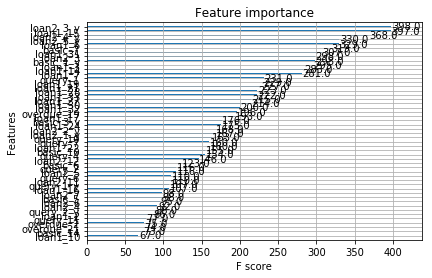

In [196]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [197]:
important_x

['loan2_3_y',
 'loan1_15',
 'loan2_4_y',
 'loan2_5_y',
 'loan1_6',
 'basic_7',
 'loan1_31',
 'loan2_3',
 'basic_1_y',
 'loan1_3',
 'loan1_14',
 'loan1_7',
 'query_1',
 'loan1_19',
 'loan1_21',
 'loan1_28',
 'loan1_33',
 'loan1_27',
 'loan1_30',
 'loan1_32',
 'overdue_19',
 'loan1_17',
 'basic_3_y',
 'loan1_24',
 'loan2_2_y',
 'loan2_1_y',
 'query_10',
 'query_7',
 'loan1_22',
 'basic_10',
 'query_4',
 'loan2_12',
 'basic_6',
 'query_2',
 'loan2_5',
 'query_6',
 'loan2_11',
 'query_1_y',
 'loan1_16',
 'loan2_7',
 'basic_5',
 'loan2_6',
 'loan2_4',
 'query_2_y',
 'loan1_2',
 'query_11',
 'overdue_2',
 'overdue_21',
 'basic_14',
 'loan1_10']

* basic_7:年龄
* 

# 输出模块

In [198]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in loss_seq])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(y_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 150

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [loss_seq[i] for i in res_num], sep="")
# print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前150个auc为[0.8044929554390564, 0.7971071923915197, 0.7695785440613027, 0.7646487739187623, 0.7566666666666667, 0.7559514919973372, 0.7557713816364335, 0.7516190763487589, 0.7506156105885021, 0.7504501915708812, 0.7471957437375305, 0.747038810483871, 0.7462647609447005, 0.7459958744110764, 0.7421421843240296, 0.7410891882464955, 0.7410449769577053, 0.7396893233751629, 0.7386194926117531, 0.7384527563892529, 0.7377819913863743, 0.7364936755215963, 0.7363436323215825, 0.7343677825017204, 0.7342801455709109, 0.7323076923076923, 0.7318932620558027, 0.7316119747232409, 0.7301626081717756, 0.7295798804510257, 0.7294518540845117, 0.7290187405424281, 0.728827448737363, 0.7284538388298989, 0.7283062623139358, 0.7278268506257495, 0.7277058445702265, 0.7276210048849368, 0.7269321275422146, 0.7245662042340164, 0.724453486717069, 0.7241747177010761, 0.7236028101080004, 0.723435299859191, 0.722750651729726, 0.7221585557501918, 0.720813349518003, 0.7208125733185128, 0.7208100686170218, 0.720318791

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？